<a href="https://colab.research.google.com/github/egyfarandikasss/House-Price-Prediction-/blob/main/Kaggle_houseprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from google.colab import files
files.upload()

In [3]:
#@title
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#@title
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [5]:
# import modules 
import numpy as np 
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Understanding Dataset

In [6]:
# read dataset 
dataset = pd.read_csv('/content/train.csv')
dataset = dataset[['MSZoning', 'LotArea', 'Street', 'LotShape', 'LandContour', 'LandSlope','HouseStyle', 'OverallQual', 
                   'YearBuilt', 'RoofStyle', 'Foundation', 'BsmtCond', 'TotalBsmtSF', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
                   'KitchenQual', 'GarageType', 'SaleType', 'SalePrice']]

In [7]:
print(dataset.shape)
dataset.head()

(1460, 22)


,MSZoning,LotArea,Street,LotShape,LandContour,LandSlope,HouseStyle,OverallQual,YearBuilt,RoofStyle,Foundation,BsmtCond,TotalBsmtSF,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageType,SaleType,SalePrice
0,RL,8450,Pave,Reg,Lvl,Gtl,2Story,7,2003,Gable,PConc,TA,856,Y,SBrkr,856,854,1710,Gd,Attchd,WD,208500
1,RL,9600,Pave,Reg,Lvl,Gtl,1Story,6,1976,Gable,CBlock,TA,1262,Y,SBrkr,1262,0,1262,TA,Attchd,WD,181500
2,RL,11250,Pave,IR1,Lvl,Gtl,2Story,7,2001,Gable,PConc,TA,920,Y,SBrkr,920,866,1786,Gd,Attchd,WD,223500
3,RL,9550,Pave,IR1,Lvl,Gtl,2Story,7,1915,Gable,BrkTil,Gd,756,Y,SBrkr,961,756,1717,Gd,Detchd,WD,140000
4,RL,14260,Pave,IR1,Lvl,Gtl,2Story,8,2000,Gable,PConc,TA,1145,Y,SBrkr,1145,1053,2198,Gd,Attchd,WD,250000


In [8]:
# define missing values and the percentage of missing values
def missing_values(df):
  total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
  percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
  return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

# check missing values in dataset
missing_values(dataset)

,Total,Percent
GarageType,81,5.55
BsmtCond,37,2.53
Electrical,1,0.07


We have 1460 umber of rows and 22 number of columns in house price dataset. There are missing values in our dataset we can handle the missing values later. We are interest to predict the sale price from the house pricing dataset based on the independent variable including all of the 21 columns above. The columns except sale price (for the next we called as independen variabel or features) are containt numerical and categorical types of dataset and our target is sale price (for next we called as a dependent variabel or target) is a numerical values. Lets analyze our target using visualization of data. 
 

In [9]:
dataset['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

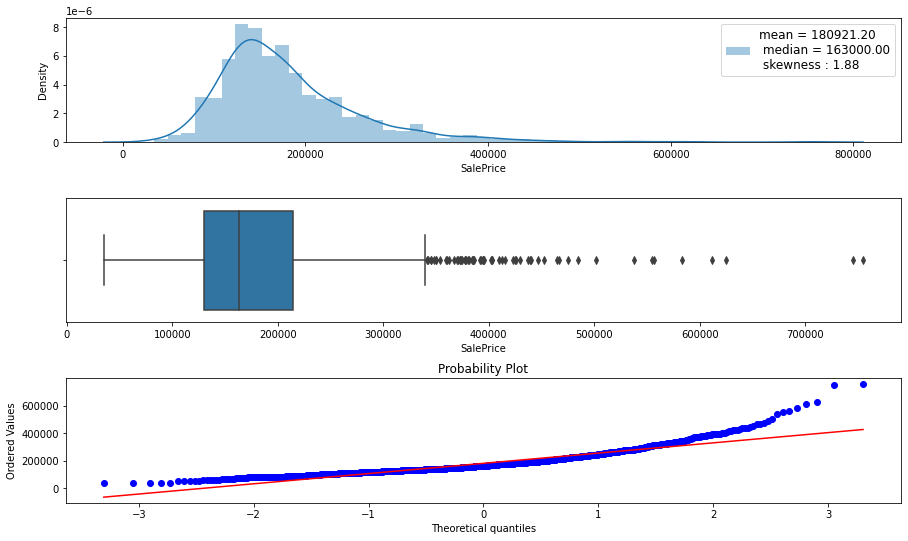

In [10]:
fig, ax = plt.subplots(3,1, figsize = (13,8))
plt.tight_layout(pad =3.5)
sns.distplot(ax = ax[0], a = dataset['SalePrice'], label = 'mean = %.2f\n median = %.2f\n skewness : %.2f'%(dataset['SalePrice'].mean(), dataset['SalePrice'].median(), dataset['SalePrice'].skew()))
sns.boxplot(ax = ax[1], x = 'SalePrice', data = dataset)
stats.probplot(dataset['SalePrice'], plot = ax[2])
ax[0].legend(loc = 'upper right', fontsize = 12)
plt.show()

We can see the density and histogram plot on our target didn't show the normal distribution since the target has a right-skewed with the values is 1.88. The normal distribution will show the visualization with bell curve and skewness value are exactly 0. Another observation shows the probability plot give information about outliers in our target.  

The features in the dataset has 2 types of including numerical and categorical types. I will explore the features in dataset with numerical and categorical data. 

In [50]:
# split features to numeric types and categorical types 
dataset_num = dataset[['LotArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'SalePrice']]
dataset_cat = dataset[['MSZoning', 'Street', 'LotShape', 'LandContour', 'LandSlope', 'HouseStyle', 'OverallQual', 'RoofStyle', 'Foundation', 'BsmtCond', 'CentralAir', 
                       'Electrical', 'KitchenQual', 'GarageType', 'SaleType']]

In [51]:
# numerical dataset 
# descriptive of numerical dataset
dataset_num2 = dataset_num.drop(['SalePrice'], axis = 1)
dataset_num2.head()

,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea
0,8450,2003,856,856,854,1710
1,9600,1976,1262,1262,0,1262
2,11250,2001,920,920,866,1786
3,9550,1915,756,961,756,1717
4,14260,2000,1145,1145,1053,2198


In [52]:
dataset_num2.describe()

,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,1971.267808,1057.429452,1162.626712,346.992466,1515.463699
std,9981.264932,30.202904,438.705324,386.587738,436.528436,525.480383
min,1300.000000,1872.000000,0.000000,334.000000,0.000000,334.000000
25%,7553.500000,1954.000000,795.750000,882.000000,0.000000,1129.500000
50%,9478.500000,1973.000000,991.500000,1087.000000,0.000000,1464.000000
75%,11601.500000,2000.000000,1298.250000,1391.250000,728.000000,1776.750000
max,215245.000000,2010.000000,6110.000000,4692.000000,2065.000000,5642.000000


We can see the description of the numerical features in dataset including measure of central tendency. The TotalBsmtSF and 2ndFlrSF has zeros values means that the house doesn't have basement and 2nd floor. Lets se the visualization of the numerical dataset. 

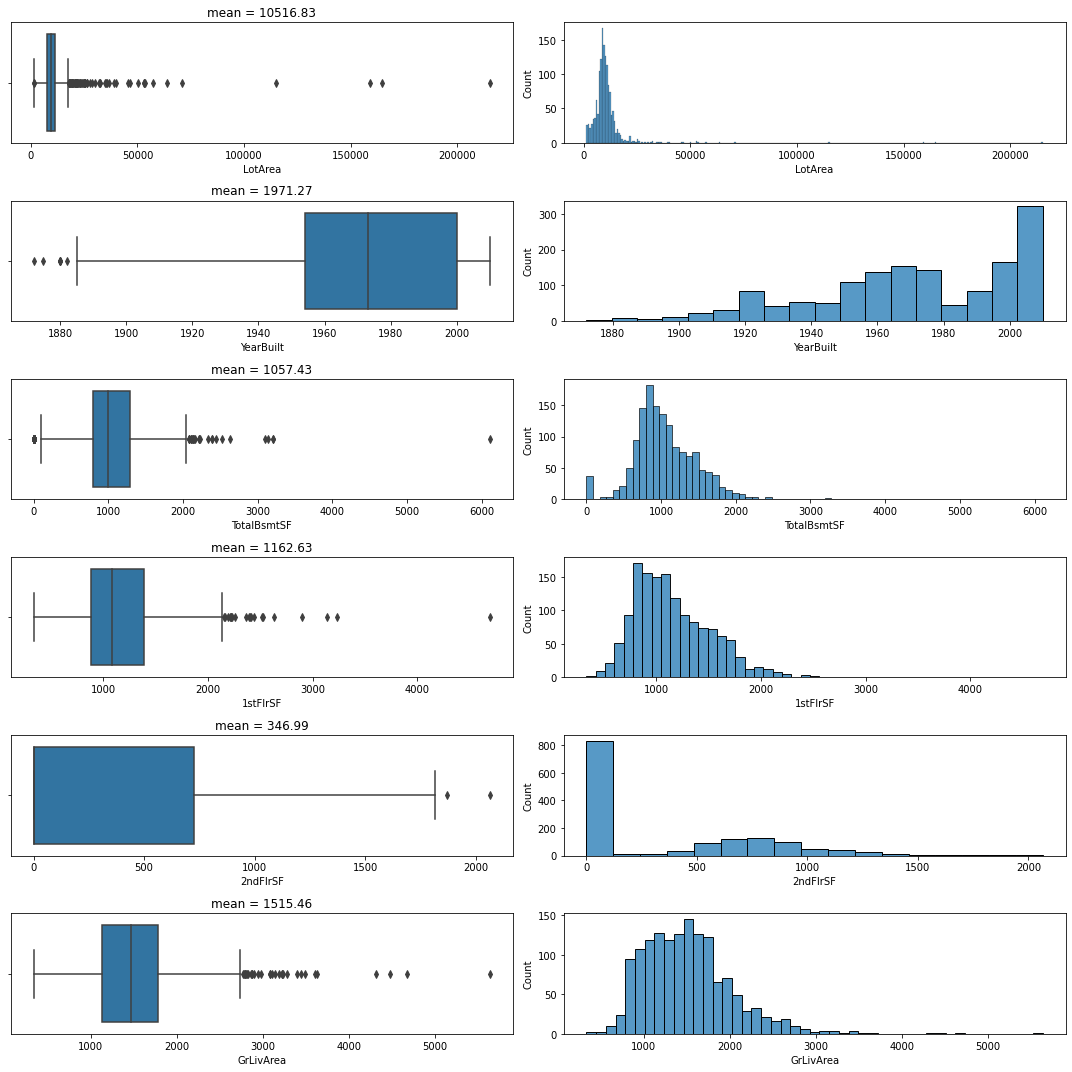

In [53]:
fig, axs = plt.subplots(6,2, figsize = (15,15))
plt.tight_layout()
for i, col in enumerate(dataset_num2):
  sns.boxplot(dataset_num2[col], ax = axs[i][0])
  sns.histplot(dataset_num2[col], ax = axs[i][1])
  axs[i][0].set_title('mean = %.2f'%(dataset_num2[col].mean()))
plt.tight_layout()
plt.show()

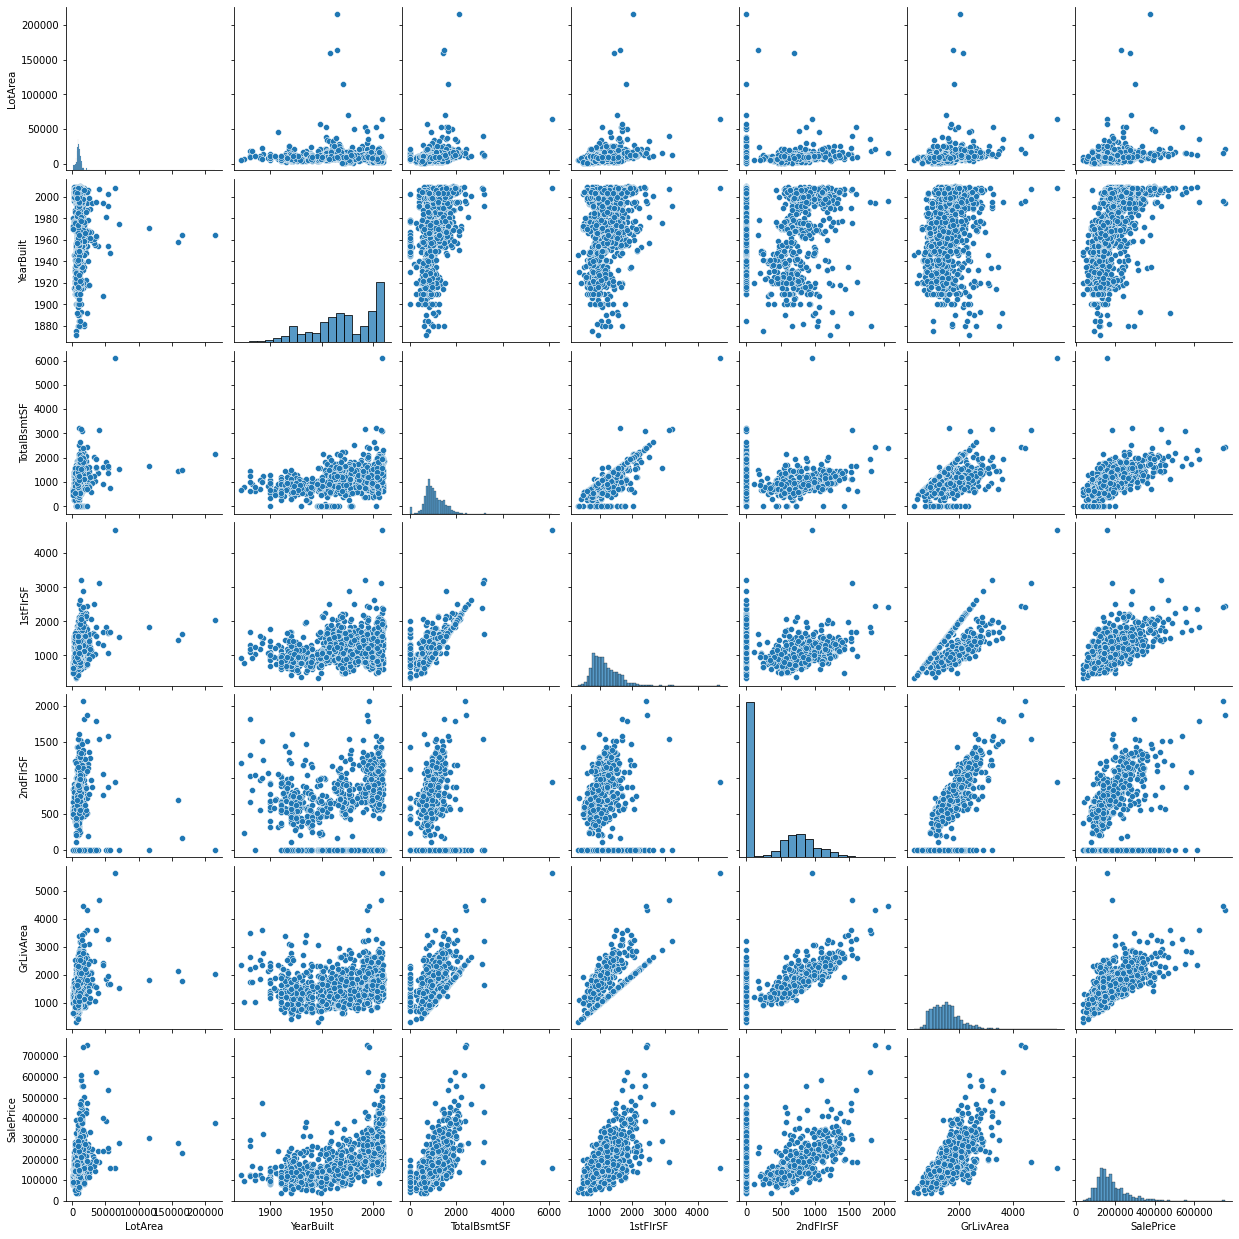

In [54]:
sns.pairplot(dataset_num)

Observation:
1. 
All of our numerical features has an outlier. 
2. TotalBsmtSF and 2ndFlrSF has zeros values means that the two features dont have the atributes. 
3. The sale price and GrLiveArea seems follow a positives trend. It is mean that if the area are more larger the price are more expensive. 

Lets explore categorical features in house price dataset.

In [55]:
for i in dataset_cat: 
  print(dataset[i].value_counts(dropna = False, sort = True))

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64
Y    1365
N   

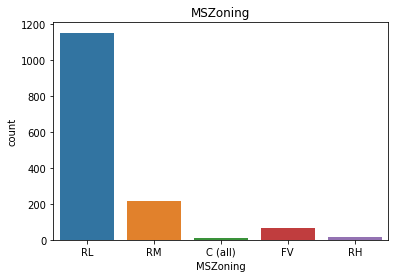

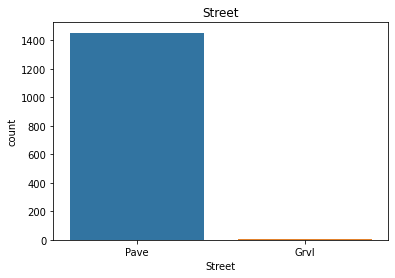

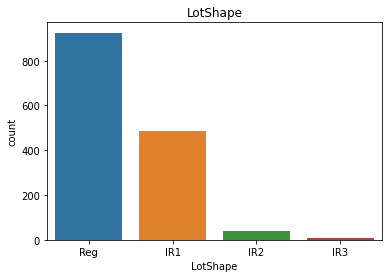

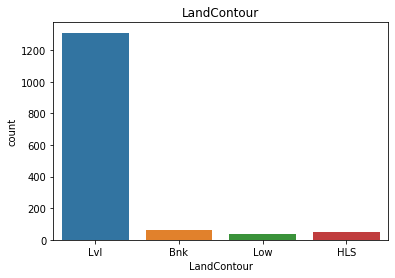

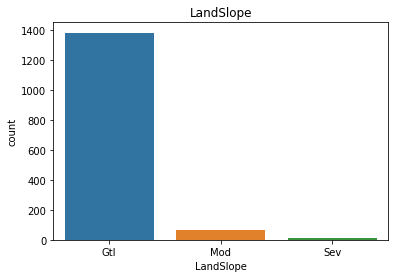

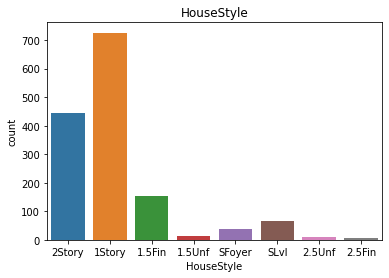

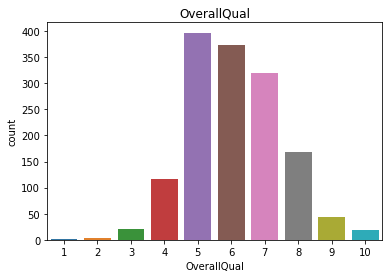

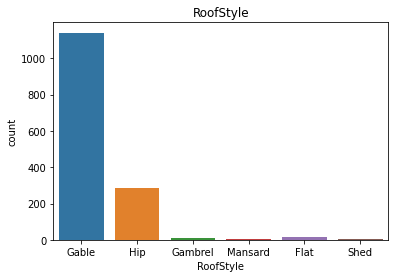

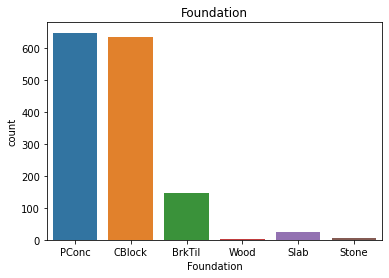

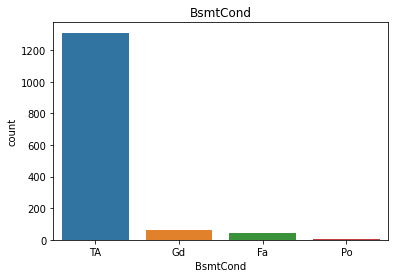

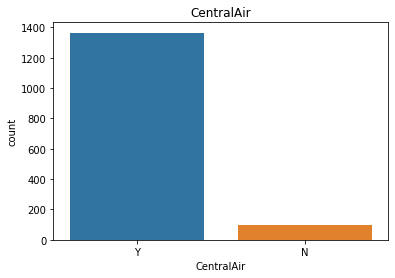

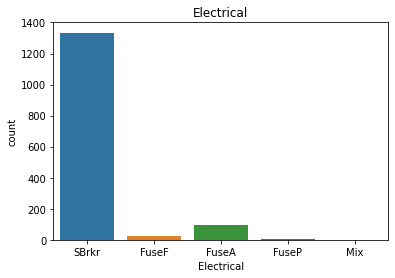

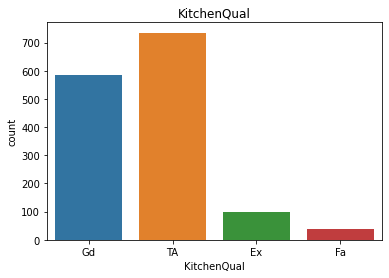

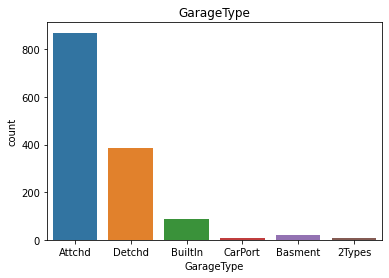

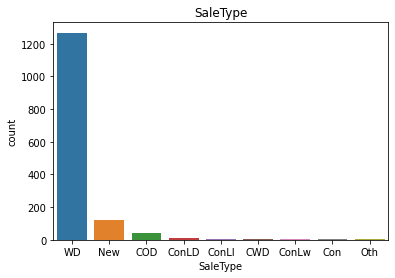

In [56]:
ax = dataset_cat
for i in ax.columns:
    sns.countplot(x = i, data = dataset_cat)
    plt.title(i)
    plt.show()

Some insight that we get from the categorical features in house price dataset is: 
1. Most types of MSZoning (general zoning classification of the sale) is RL (Residential Low Density).
2. Only 6 house have 6 gravel street. 
3. Most house has Lotshape Regular and Slightly Iregular.
4. Almost all house has landcontour with lvl (near flat/lvl)
5. Most of house has landslope Gtl(Gentle slope)
6. We have 8 types of house dwelling styles and 1story is the most house style
7. There are 10 quality of house with scale from 1 to 10. Most of house has quality about 5 or 6. There are few house have score 10. 
8. The Gable roof are dominant in house price dataset. 
9. Most of house use Pconc and CBlock as fondation. 
10. Mosth of house has Ta Type basement condition
11. About 1365 house have air condition. 
12. Most house use SBrkr (Standard Circuit Breakers) & Romex as an electrical types. 
13. Most of the house in sale price dataset has Good and average (TA) kitchen quality
14. Most of house has Attached to home garage but there are few house don't have garages. 
15. Most of the house are sale by WD Warranty Deed - Conventional. 